In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from onep.subset import first_x, last_x, trials_between, random_subset
from onep.alignment import align_to_block, average_trace, downsample_time
from onep.norm import min_max_norm, gaussian_smooth, zscore_norm
from onep.compare import (
    auc_comp, 
    compare_around_aligned, 
    summarise_prepost_around_aligned, 
    auc, 
    paired_ttest_prepost
)
from onep.plots import aligned_heatmap, aligned_plot
from onep.utils import create_combined_col

from spiketimes.df.alignment import align_around


In [2]:
MICE = [
    {"name": "B51618", "path": Path(r"E:\exports\B51618"), "group": "exp"},
    {"name": "B51622", "path": Path(r"E:\exports\B51622"), "group": "no shock"},
    {"name": "B51629", "path": Path(r"E:\exports\B51629"), "group": "one context"}
]
SHOCK = np.array([240, 300, 360, 420, 480, 540])
CONTEXTS = np.arange(6) * 120
CONTEXT_NAMES = ["safe", "shock"]

In [3]:
def load_day3_df(p):
    return pd.read_csv(p / "day3-noon" / "traces_updated.csv")

def load_day4_df(p):
    return (
        pd.read_csv(p / "day4-test1" / "traces_updated.csv")
        .pipe(lambda x: 
            which_bin(x, CONTEXTS, spiketimes_col="time").assign(context= lambda x: x.bin_idx.apply(lambda x: CONTEXT_NAMES[int(x % 2)]))
        )
    )

def load(loader):
    dfs = []
    for d in MICE:
        dfs.append(
            loader(d["path"]).assign(name=d["name"], group=d["group"])
        )
    return pd.concat(dfs)

In [4]:
df_d3 = load(loader=load_day3_df)
# df_d3 = align_around(df_d3, data_colname="time", events=SHOCK, t_before=10, max_latency=10).dropna().head(4)

In [11]:
from spiketimes.df.binning import which_bin


df = (
    df_d3
    .pipe(lambda x: which_bin(
        x,
        SHOCK,
        spiketimes_col="time",
        before=20,
        allow_before=False,
        max_latency=10
        ).rename(columns={"bin_idx": "trial_number"})
    )
    .drop("bin_values", axis=1)
    .pipe(align_around, events=SHOCK, data_colname="time", t_before=20, max_latency=10)
    .dropna()
)

In [12]:

def plot_day3_shock_heatmap(group, vmin, vmax):
    dfp = (
        df
        .loc[lambda x: x.group==group]
        .pipe(
            downsample_time,
            sampling_interval=0.2,
            time_col="aligned",
            other_cols=["cell_id", "trial_number"]
        )
        .pipe(
            gaussian_smooth,
            cell_col="cell_id", other_cols=["trial_number"], 
            sigma=1
            )
        .pipe(average_trace, data_value_col="smooth", cell_col="cell_id")
        .pipe(zscore_norm, value_col="smooth")
    )
    res = (
        df
        .loc[lambda x: x.group == group]
        .pipe(
            summarise_prepost_around_aligned, 
            func_=auc, grouping_cols=["cell_id", "trial_number"], data_col="value"
            )
        .pipe(
            paired_ttest_prepost,
            grouping_cols=["cell_id"]
        )
        .assign(
            sig = lambda x: x.p_adj < 0.05
            )
    )
    idx = (
            res
            .sort_values("statistic")
            .cell_id.values
        )

    return aligned_heatmap(dfp, value_col="zscore_norm", cmap="coolwarm", round_xticks=1, num_xticks=6, idx=idx,
        cbar_label="Z Scored Floressance", vmin=vmin, vmax=vmax)

c:\users\roryl\repos\onep\onep\compare.py:72: UserWarning: Prepost events with not enough data: 1320
  warnings.warn(msg)


(<matplotlib.image.AxesImage at 0x1f00d86d448>,
 <matplotlib.colorbar.Colorbar at 0x1f012577508>)

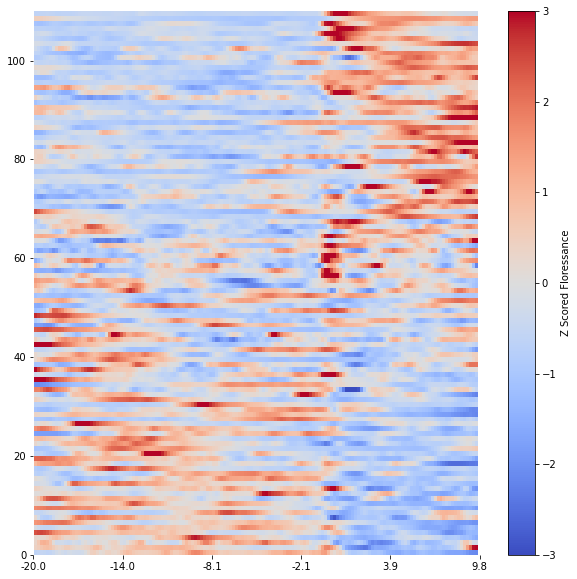

In [13]:
plot_day3_shock_heatmap("exp", -3, 3)

c:\users\roryl\repos\onep\onep\compare.py:72: UserWarning: Prepost events with not enough data: 552
  warnings.warn(msg)


(<matplotlib.image.AxesImage at 0x1f00dbe54c8>,
 <matplotlib.colorbar.Colorbar at 0x1f00df14f08>)

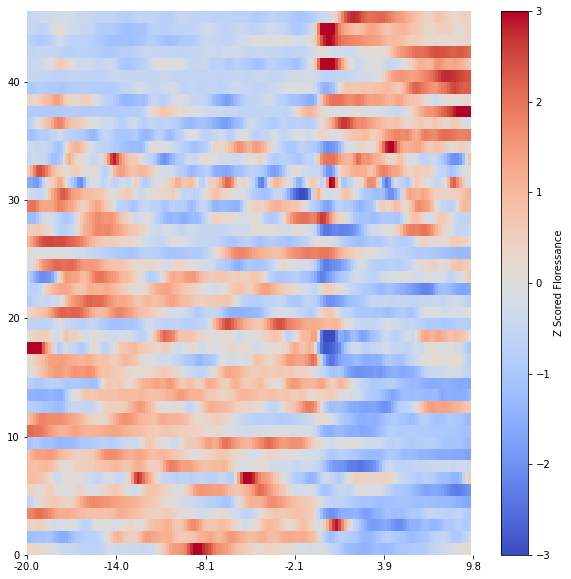

In [14]:
plot_day3_shock_heatmap("one context", -3, 3)

c:\users\roryl\repos\onep\onep\compare.py:72: UserWarning: Prepost events with not enough data: 300
  warnings.warn(msg)


(<matplotlib.image.AxesImage at 0x1f00fe46d88>,
 <matplotlib.colorbar.Colorbar at 0x1f016d0ff48>)

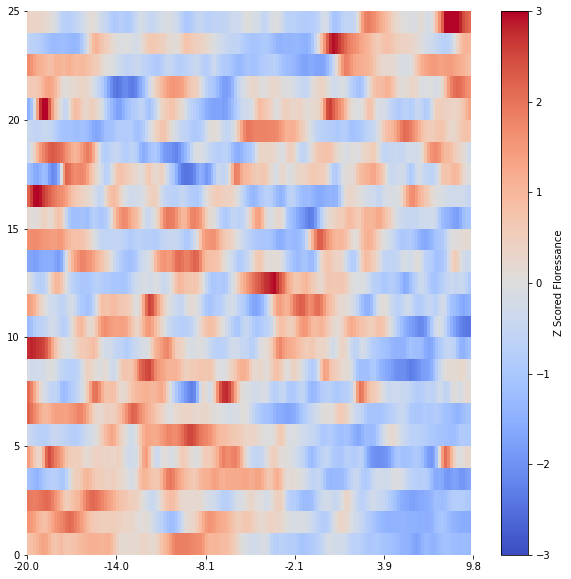

In [16]:
plot_day3_shock_heatmap("no shock", -3, 3)